In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import random

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


In [5]:
# x_train_part = x_train[:86,:]
# print(x_train_part.shape)

# y_train_part = y_train[:86]
# print(y_train_part.shape)

## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [6]:
def cross_validation(x_train, y_train, k=5):
    KFoldData = []
    num_of_data = x_train.shape[0]
    # Get all training data's indices and shuffle the ordering
    data_indices = np.arange(num_of_data)
    random.shuffle(data_indices)

    if num_of_data % k == 0:
        # Create k splits to become validation folds
        valFolds = np.split(data_indices, k, axis=0)
        for i in range(k):
            currentSplit = []
            val_fold = np.sort(valFolds[i])
            train_fold = np.setdiff1d(data_indices, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)
    else:
        """ 
        When num_of_data is not divisible by K:
        The first (n_samples % n_splits) folds have size (n_samples // n_splits + 1),
        other folds have size (n_samples // n_splits), where n_samples is the number of samples.
        """
        num_of_firstValFolds = num_of_data % k
        num_of_otherValFolds = k - num_of_firstValFolds
        size_of_each_firstValFold = num_of_data // k + 1
        size_of_each_otherValFold = num_of_data // k
        data_of_firstValFolds = data_indices[:num_of_firstValFolds*size_of_each_firstValFold]
        data_of_otherValFolds = np.setdiff1d(data_indices, data_of_firstValFolds)

        # For first parts
        firstValFolds = np.split(data_of_firstValFolds, num_of_firstValFolds, axis=0)
        for i in range(num_of_firstValFolds):
            currentSplit = []
            val_fold = np.sort(firstValFolds[i])
            train_fold = np.setdiff1d(data_of_firstValFolds, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)

        # For other parts
        otherValFolds = np.split(data_of_otherValFolds, num_of_otherValFolds, axis=0)
        for i in range(num_of_otherValFolds):
            currentSplit = []
            val_fold = np.sort(otherValFolds[i])
            train_fold = np.setdiff1d(data_of_otherValFolds, val_fold)
            currentSplit.append(train_fold)
            currentSplit.append(val_fold)
            KFoldData.append(currentSplit)

    return KFoldData

In [7]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

In [8]:
# test_kfold_data = cross_validation(x_train_part, y_train_part, k=10)

# for i in range(10):
#     print(f'Split {i}')
#     print(test_kfold_data[i])

## example

In [9]:
# from sklearn.model_selection import KFold

# X = np.arange(20)
# kf = KFold(n_splits=5, shuffle=True)
# kfold_data= []
# for i, (train_index, val_index) in enumerate(kf.split(X)):
#     print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
#     kfold_data.append([train_index, val_index])

In [10]:
# assert len(kfold_data) == 5 # should contain 5 fold of data
# assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
# assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [11]:
def getDataFromIdx(x_train, y_train, each_kfold_data):
    # For training fold
    indices = each_kfold_data[0]
    x_train_subset = x_train[np.ix_(indices)]
    y_train_subset = y_train[np.ix_(indices)]

    # For validation fold
    indices = each_kfold_data[1]
    x_val = x_train[np.ix_(indices)]
    y_val = y_train[np.ix_(indices)]
    
    return x_train_subset, y_train_subset, x_val, y_val

In [12]:
def runCrossValidation(c, gamma, kfold_data):
    """ k-fold Cross Validation """
    k = len(kfold_data)
    total_score = 0

    for i in range(k):
        x_train_subset, y_train_subset, x_val, y_val = getDataFromIdx(x_train, y_train, kfold_data[i])
        clf = SVC(C=c, kernel='rbf', gamma=gamma)
        clf.fit(x_train_subset, y_train_subset)
        y_pred = clf.predict(x_val)
        current_accuracy = accuracy_score(y_pred, y_val)
        # print(f'(C:{c}, gamma:{gamma} -> accuracy:{current_accuracy})')
        total_score += current_accuracy

    return total_score / k

In [13]:
""" Grid search to find the best C and gamma """
C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
Gamma_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
accuracy_list = []
best_accuracy = 0.0
best_C, best_gamma = None, None

for c in C_list:
    for gamma in Gamma_list:
        # For current hyperparameter setting, run cross validation and get the average score
        avg_accuracy = runCrossValidation(c, gamma, kfold_data)
        print(f'====== average score of hyp[C:{c}, gamma:{gamma}] -> {avg_accuracy} ======')
        accuracy_list.append(avg_accuracy)

        if(best_accuracy < avg_accuracy):
            best_accuracy =  avg_accuracy
            best_C = c
            best_gamma = gamma

# Transform the accuracy list to ndarray (for plotting heatmap)
accuracy_arr = np.array(accuracy_list).reshape(len(C_list), len(Gamma_list))

====== average score of hyp[C:0.001, gamma:1e-05] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:0.0001] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:0.001] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:0.01] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:0.1] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:1.0] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:10.0] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:100.0] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:1000.0] -> 0.6890909090909091 ======
====== average score of hyp[C:0.001, gamma:10000.0] -> 0.6890909090909091 ======
====== average score of hyp[C:0.01, gamma:1e-05] -> 0.6890909090909091 ======
====== average score of hyp[C:0.01, gamma:0.0001] -> 0.6890909090909091 ======
====== average score of hyp[C:0.01, gamma:0.001] -> 0.6

In [14]:
print('best_accuracy:', best_accuracy)
print(f'best_parameters: [C:{best_C}, gamma:{best_gamma}]')

best_accuracy: 0.8945454545454545
best_parameters: [C:10.0, gamma:0.001]


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

Text(0.5, 1.0, 'Hyperparameter GridSearch')

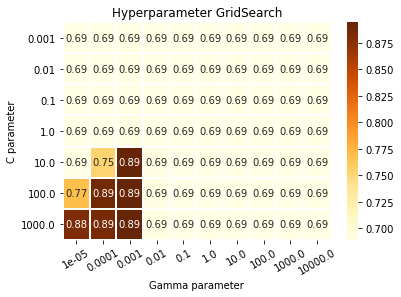

In [15]:
import matplotlib as plt
import seaborn as sns

ax = sns.heatmap(accuracy_arr, annot=True, fmt=".2f", cmap="YlOrBr", linewidths=1, linecolor='white')
ax.set_xticklabels(Gamma_list, rotation=30)
ax.set_yticklabels(C_list, rotation=0)
ax.set(xlabel='Gamma parameter', ylabel='C parameter')
ax.set_title("Hyperparameter GridSearch")

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [16]:
# Do the SVM on whole training set based on the best hyperparameters we just found
best_model = SVC(C=best_C, kernel='rbf', gamma=best_gamma)
best_model.fit(x_train, y_train)

SVC(C=10.0, gamma=0.001)

In [17]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of the model you have implemented in HW1 with the SVM

### HW1

In [8]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1)

In [42]:
print("Square error of Linear regression: ")
print("Square error of SVM regresssion model: ")

Square error of Linear regression: 
Square error of SVM regresssion model: 
